In [ ]:

!pip install --quiet pulp simpy statsmodels scikit-learn matplotlib pandas numpy


In [ ]:

import os, random
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


random.seed(42)
np.random.seed(42)


%matplotlib inline


In [ ]:
N_DAYS = 180
start_date = (datetime.today() - timedelta(days=N_DAYS)).replace(hour=0, minute=0, second=0, microsecond=0)
dates = [start_date + timedelta(days=i) for i in range(N_DAYS)]

departments = ["General", "Cardiology", "Orthopedics", "Radiology", "ENT"]

doctors = [{"doctor_id": f"D{i+1}", "specialty": departments[i % len(departments)]} for i in range(12)]

appointments = []
appt_id = 0
for d in dates:
    weekday = d.weekday()
    base = 80 if weekday < 5 else 40
    daily = max(5, int(np.random.poisson(base)))
    for _ in range(daily):
        appt_id += 1

        sched_min = int(np.random.uniform(8*60, 17*60))
        scheduled_time = datetime.combine(d.date(), datetime.min.time()) + timedelta(minutes=sched_min)
        patient_arrival_offset = int(np.random.normal(loc=5, scale=8))
        canceled = (np.random.rand() < 0.03)
        no_show = (np.random.rand() < 0.02)
        doc = random.choice(doctors)
        consult_mean = 15 + (departments.index(doc["specialty"]) * 2)
        consult_time = max(5, int(np.random.normal(loc=consult_mean, scale=6)))
        check_in = None if canceled or no_show else (scheduled_time + timedelta(minutes=patient_arrival_offset))
        check_out = None if canceled or no_show else (check_in + timedelta(minutes=consult_time))
        appointments.append({
            "appointment_id": appt_id,
            "date": d.date(),
            "scheduled_time": scheduled_time,
            "check_in": check_in,
            "check_out": check_out,
            "doctor_id": doc["doctor_id"],
            "department": doc["specialty"],
            "consult_minutes": consult_time if not (canceled or no_show) else np.nan,
            "canceled": canceled,
            "no_show": no_show,
            "age": int(np.random.choice(range(1, 90)))
        })

appointments_df = pd.DataFrame(appointments)
print("Rows generated:", len(appointments_df))
appointments_df.head(5)

Rows generated: 12512


,appointment_id,date,scheduled_time,check_in,check_out,doctor_id,department,consult_minutes,canceled,no_show,age
0,1,2025-04-18,2025-04-18 14:35:00,2025-04-18 14:32:00,2025-04-18 14:52:00,D8,Orthopedics,20.0,False,False,88
1,2,2025-04-18,2025-04-18 11:00:00,2025-04-18 11:08:00,2025-04-18 11:17:00,D1,General,9.0,False,False,30
2,3,2025-04-18,2025-04-18 09:54:00,2025-04-18 09:55:00,2025-04-18 10:09:00,D12,Cardiology,14.0,False,False,89
3,4,2025-04-18,2025-04-18 10:37:00,2025-04-18 10:34:00,2025-04-18 10:52:00,D12,Cardiology,18.0,False,False,62
4,5,2025-04-18,2025-04-18 08:48:00,2025-04-18 08:42:00,2025-04-18 09:13:00,D5,ENT,31.0,False,False,51


In [ ]:

appointments_df["scheduled_time"] = pd.to_datetime(appointments_df["scheduled_time"])
appointments_df["check_in"] = pd.to_datetime(appointments_df["check_in"])
appointments_df["check_out"] = pd.to_datetime(appointments_df["check_out"])


appointments_df["waiting_minutes"] = (appointments_df["check_in"] - appointments_df["scheduled_time"]).dt.total_seconds() / 60.0

appointments_df.loc[appointments_df["canceled"] | appointments_df["no_show"], "waiting_minutes"] = np.nan
appointments_df["consult_minutes"] = pd.to_numeric(appointments_df["consult_minutes"], errors="coerce")

print("waiting minutes summary (non-NaN):")
display(appointments_df["waiting_minutes"].describe())
print("\nCancellations / no-shows counts:")
display(appointments_df[["canceled","no_show"]].sum())


waiting minutes summary (non-NaN):


,waiting_minutes
count,11862.000000
mean,4.802310
std,7.769872
min,-27.000000
25%,0.000000
50%,4.000000
75%,10.000000
max,34.000000



Cancellations / no-shows counts:


,0
canceled,389
no_show,273


Average waiting time by department (minutes):


,waiting_minutes
department,
Orthopedics,5.051333
ENT,5.037551
Cardiology,4.743074
General,4.678933
Radiology,4.582719



Daily arrivals (head):


,arrivals
date,
2025-04-18,77
2025-04-19,42
2025-04-20,44
2025-04-21,89
2025-04-22,84


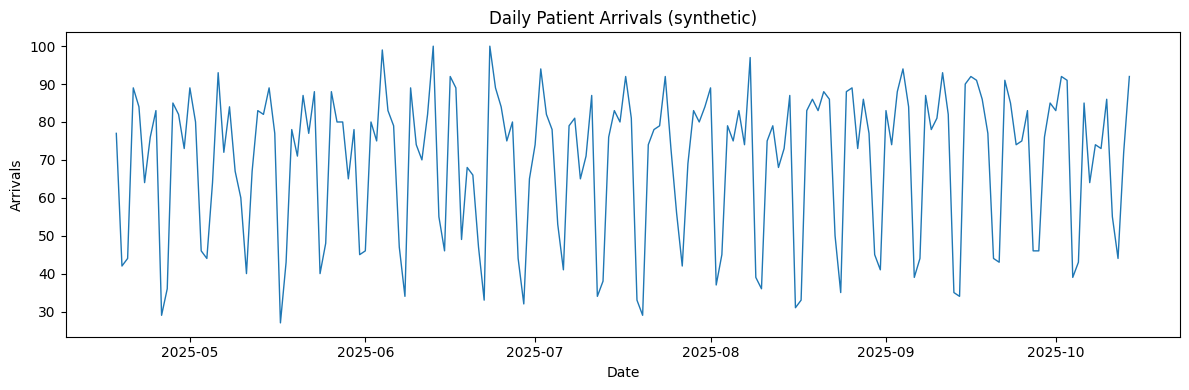

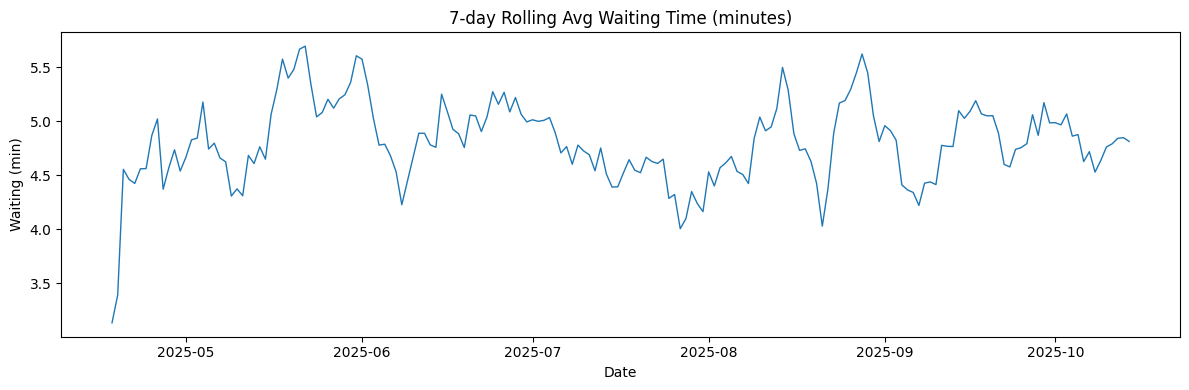

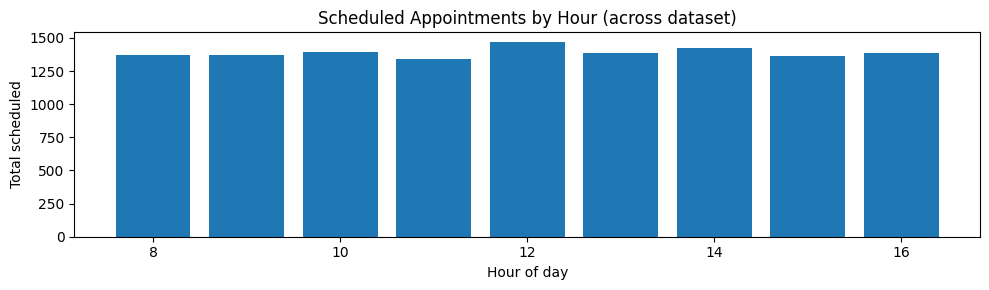

In [ ]:



waiting_by_dept = appointments_df.groupby("department")["waiting_minutes"].mean().sort_values(ascending=False)
print("Average waiting time by department (minutes):")
display(waiting_by_dept)


daily_counts = appointments_df.groupby("date").size().rename("arrivals").reset_index()
daily_counts["date"] = pd.to_datetime(daily_counts["date"])
daily_counts.set_index("date", inplace=True)
print("\nDaily arrivals (head):")
display(daily_counts.head())


plt.figure(figsize=(12,4))
plt.plot(daily_counts.index, daily_counts["arrivals"], linewidth=1)
plt.title("Daily Patient Arrivals (synthetic)")
plt.xlabel("Date"); plt.ylabel("Arrivals")
plt.tight_layout(); plt.show()


wt_daily = appointments_df.dropna(subset=["waiting_minutes"]).groupby("date")["waiting_minutes"].mean()
wt_daily = wt_daily.rolling(7, min_periods=1).mean()
plt.figure(figsize=(12,4))
plt.plot(wt_daily.index, wt_daily.values, linewidth=1)
plt.title("7-day Rolling Avg Waiting Time (minutes)")
plt.xlabel("Date"); plt.ylabel("Waiting (min)")
plt.tight_layout(); plt.show()


appointments_df["hour"] = appointments_df["scheduled_time"].dt.hour
hour_counts = appointments_df.groupby("hour").size()
plt.figure(figsize=(10,3))
plt.bar(hour_counts.index, hour_counts.values)
plt.title("Scheduled Appointments by Hour (across dataset)")
plt.xlabel("Hour of day"); plt.ylabel("Total scheduled")
plt.tight_layout(); plt.show()


/tmp/ipython-input-3260849736.py:4: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  series = daily_counts["arrivals"].asfreq("D").fillna(method="ffill")
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


14-day arrival forecast (first rows):


,date,predicted_arrivals,lower_ci,upper_ci
0,2025-10-15,85.042803,54.918224,115.167383
1,2025-10-16,70.083854,39.895513,100.272195
2,2025-10-17,61.149748,27.260734,95.038762
3,2025-10-18,62.194253,25.564244,98.824263
4,2025-10-19,68.381103,31.676020,105.086186


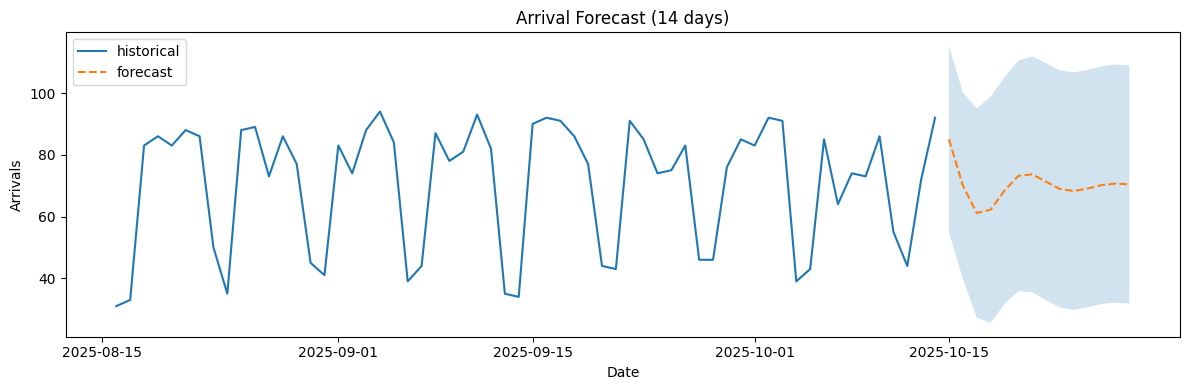

from matplotlib import pyplot as plt
_df_0['index'].plot(kind='hist', bins=20, title='index')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['predicted_arrivals'].plot(kind='hist', bins=20, title='predicted_arrivals')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2['lower_ci'].plot(kind='hist', bins=20, title='lower_ci')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3['upper_ci'].plot(kind='hist', bins=20, title='upper_ci')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_4.plot(kind='scatter', x='index', y='predicted_arrivals', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_5.plot(kind='scatter', x='predicted_arrivals', y='lower_ci', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_6.plot(kind='scatter', x='lower_ci', y='upper_ci', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['date']
  ys = series['predicted_arrivals']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_7.sort_values('date', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('date')
_ = plt.ylabel('predicted_arrivals')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['date']
  ys = series['lower_ci']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_8.sort_values('date', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('date')
_ = plt.ylabel('lower_ci')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['date']
  ys = series['upper_ci']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_9.sort_values('date', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('date')
_ = plt.ylabel('upper_ci')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['date']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'date'}, axis=1)
              .sort_values('date', ascending=True))
  xs = counted['date']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_10.sort_values('date', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('date')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
_df_11['index'].plot(kind='line', figsize=(8, 4), title='index')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_12['predicted_arrivals'].plot(kind='line', figsize=(8, 4), title='predicted_arrivals')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_13['lower_ci'].plot(kind='line', figsize=(8, 4), title='lower_ci')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_14['upper_ci'].plot(kind='line', figsize=(8, 4), title='upper_ci')
plt.gca().spines[['top', 'right']].set_visible(False)

In [ ]:

from statsmodels.tsa.arima.model import ARIMA


series = daily_counts["arrivals"].asfreq("D").fillna(method="ffill")


try:
    model = ARIMA(series, order=(2,1,2))
    res = model.fit()
    forecast_steps = 14
    fc = res.get_forecast(steps=forecast_steps)
    fc_mean = fc.predicted_mean
    fc_ci = fc.conf_int()
    fc_df = pd.DataFrame({
        "date": pd.date_range(start=series.index.max() + pd.Timedelta(days=1), periods=forecast_steps),
        "predicted_arrivals": fc_mean.values,
        "lower_ci": fc_ci.iloc[:,0].values,
        "upper_ci": fc_ci.iloc[:,1].values
    })
    print("14-day arrival forecast (first rows):")
    display(fc_df.head())

    plt.figure(figsize=(12,4))
    plt.plot(series.index[-60:], series.values[-60:], label="historical")
    plt.plot(fc_df["date"], fc_df["predicted_arrivals"], linestyle="--", label="forecast")
    plt.fill_between(fc_df["date"], fc_df["lower_ci"], fc_df["upper_ci"], alpha=0.2)
    plt.legend(); plt.title("Arrival Forecast (14 days)"); plt.xlabel("Date"); plt.ylabel("Arrivals")
    plt.tight_layout(); plt.show()
except Exception as e:
    print("ARIMA fitting/forecast failed:", e)


In [ ]:

import pulp


doctors_df = pd.DataFrame(doctors)
doctors_df["max_shifts_per_week"] = 5


dept_dist = appointments_df["department"].value_counts(normalize=True).reindex(departments).fillna(0)

if 'fc_df' in globals():
    predicted_total_next_week = int(max(1, round(fc_df["predicted_arrivals"].mean() * 7)))
else:
    predicted_total_next_week = int(max(1, round(series[-7:].mean() * 7)))
dept_forecast = (dept_dist * predicted_total_next_week).round().astype(int).to_dict()
print("Coarse dept forecast for next week:")
display(dept_forecast)


days_to_schedule = 7
shift_slots = [(day, shift) for day in range(days_to_schedule) for shift in ["M","A"]]
num_slots = len(shift_slots)

prob = pulp.LpProblem("Doctor_Scheduling", pulp.LpMinimize)
assign = pulp.LpVariable.dicts("assign", (doctors_df.index, range(num_slots)), lowBound=0, upBound=1, cat="Binary")


prob += pulp.lpSum(assign[i][s] for i in doctors_df.index for s in range(num_slots))


dept_min_per_day = {dept: (1 if dept_dist[dept] >= (1.0/len(departments)) else 0) for dept in departments}
doc_dept_map = doctors_df["specialty"].to_dict()

for day_idx in range(days_to_schedule):
    slot_idxs = [s_idx for s_idx, (d,sh) in enumerate(shift_slots) if d == day_idx]
    for dept in departments:
        prob += pulp.lpSum(assign[i][s] for i in doctors_df.index if doc_dept_map[i]==dept for s in slot_idxs) >= dept_min_per_day[dept]


for i in doctors_df.index:
    prob += pulp.lpSum(assign[i][s] for s in range(num_slots)) <= doctors_df.loc[i, "max_shifts_per_week"]


prob.solve(pulp.PULP_CBC_CMD(msg=False))


schedule = []
for s_idx, (day_idx, shift_label) in enumerate(shift_slots):
    assigned_docs = [doctors_df.loc[i, "doctor_id"] for i in doctors_df.index if pulp.value(assign[i][s_idx]) == 1]
    schedule.append({
        "date": (datetime.today() + timedelta(days=day_idx)).date(),
        "shift": shift_label,
        "assigned_doctors": ", ".join(assigned_docs) if assigned_docs else ""
    })
schedule_df = pd.DataFrame(schedule)
print("Sample schedule:")
display(schedule_df.head(10))


Coarse dept forecast for next week:


{'General': 122,
 'Cardiology': 125,
 'Orthopedics': 84,
 'Radiology': 79,
 'ENT': 80}

Sample schedule:


,date,shift,assigned_doctors
0,2025-10-15,M,D11
1,2025-10-15,A,D12
2,2025-10-16,M,
3,2025-10-16,A,"D1, D7"
4,2025-10-17,M,D2
5,2025-10-17,A,D1
6,2025-10-18,M,"D11, D12"
7,2025-10-18,A,
8,2025-10-19,M,D12
9,2025-10-19,A,D1


In [ ]:

import simpy

def simulate_queue(arrival_rate_per_hour=6, avg_service_min=15, sim_hours=8, random_seed=42):
    random.seed(random_seed); np.random.seed(random_seed)
    env = simpy.Environment()
    server = simpy.Resource(env, capacity=1)
    wait_times = []

    def patient(env, name):
        arrive_time = env.now
        with server.request() as req:
            yield req
            wait = env.now - arrive_time
            wait_times.append(wait)
            service = max(1.0, random.expovariate(1.0/avg_service_min))
            yield env.timeout(service)

    def arrival_process(env, rate_per_hour):
        if rate_per_hour <= 0:
            return
        while env.now < sim_hours * 60:
            inter = random.expovariate(rate_per_hour / 60.0)
            yield env.timeout(inter)
            env.process(patient(env, "p"))

    env.process(arrival_process(env, arrival_rate_per_hour))
    env.run(until=sim_hours * 60)
    return wait_times


rates = [3, 6, 9]
sim_results = {}
for r in rates:
    waits = simulate_queue(arrival_rate_per_hour=r, avg_service_min=15, sim_hours=8)
    sim_results[r] = {"avg_wait_min": np.mean(waits) if waits else np.nan, "median_wait": np.median(waits) if waits else np.nan, "n_served": len(waits)}

print("Simulation results (per hour rate -> average wait in minutes):")
display(pd.DataFrame.from_dict(sim_results, orient="index"))


Simulation results (per hour rate -> average wait in minutes):


,avg_wait_min,median_wait,n_served
3,22.637637,19.779571,30
6,37.671960,29.210677,40
9,67.185342,56.117078,36


In [ ]:

out_dir = "/content/hospital_demo_outputs"
os.makedirs(out_dir, exist_ok=True)
appointments_df.to_csv(os.path.join(out_dir, "appointments_synthetic.csv"), index=False)
daily_counts.to_csv(os.path.join(out_dir, "daily_arrivals.csv"))
schedule_df.to_csv(os.path.join(out_dir, "example_schedule.csv"), index=False)
print(f"Saved: {out_dir}/appointments_synthetic.csv, daily_arrivals.csv, example_schedule.csv")


print("\nRecommendations:")
print("1) Deploy a real-time dashboard (Power BI / Tableau / Dash) for arrivals, waits, occupancy.")
print("2) Integrate EHR/appointment logs for accurate timestamps (check-in, consult start/end).")
print("3) Use dept-level arrival forecasts to schedule staff dynamically via ILP.")
print("4) Validate scheduling via SimPy simulations before rollout (test extra servers, fast-track lanes).")
print("5) Consider check-in kiosks / mobile check-in to reduce manual timestamp errors.")


Saved: /content/hospital_demo_outputs/appointments_synthetic.csv, daily_arrivals.csv, example_schedule.csv

Recommendations:
1) Deploy a real-time dashboard (Power BI / Tableau / Dash) for arrivals, waits, occupancy.
2) Integrate EHR/appointment logs for accurate timestamps (check-in, consult start/end).
3) Use dept-level arrival forecasts to schedule staff dynamically via ILP.
4) Validate scheduling via SimPy simulations before rollout (test extra servers, fast-track lanes).
5) Consider check-in kiosks / mobile check-in to reduce manual timestamp errors.
